In [11]:
# Cell 1: Imports
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, r2_score
from xgboost import XGBRegressor
from datetime import datetime, timedelta
import pickle
from sklearn.preprocessing import StandardScaler, OneHotEncoder
import warnings
warnings.filterwarnings('ignore')

In [68]:
import os

# Save preprocessed data and scaler
df.to_csv('preprocessed_menstrual_data_optimized.csv', index=False)
with open('scaler.pkl', 'wb') as f:
    pickle.dump(scaler, f)

# Verify file creation
if os.path.exists('preprocessed_menstrual_data_optimized.csv'):
    print(f"Preprocessed data saved to: {os.path.abspath('preprocessed_menstrual_data_optimized.csv')}")
else:
    print("Error: Failed to save preprocessed_menstrual_data_optimized.csv")
print(f"Current working directory: {os.getcwd()}")

Preprocessed data saved to: d:\Projects\menstrual_cycle_prediction\preprocessed_menstrual_data_optimized.csv
Current working directory: d:\Projects\menstrual_cycle_prediction


In [2]:
# Load the dataset
df = pd.read_csv('FedCycleData071012 (2).csv')

In [3]:
relevant_columns = [
    'ClientID',  # For grouping
    'LengthofCycle', 'MeanCycleLength', 'EstimatedDayofOvulation', 
    'LengthofLutealPhase', 'Age', 'BMI', 'LengthofMenses', 
    'MeanMensesLength', 'TotalMensesScore'
]

# Check if 'ClientID' exists in the dataset
if 'ClientID' not in df.columns:
    print("Warning: 'ClientID' not found in dataset. Variability features will be set to 0.")
    df['ClientID'] = 1  # Assign a dummy ClientID

# Drop irrelevant columns
df = df[relevant_columns]

In [4]:
# Convert columns to numeric, coercing errors (e.g., empty strings) to NaN
for col in relevant_columns:
    if col != 'LengthofCycle':  # LengthofCycle is already int
        df[col] = pd.to_numeric(df[col], errors='coerce')

# Handle missing values
df = df.dropna(subset=['LengthofCycle', 'EstimatedDayofOvulation'])  # Drop rows missing key targets
for col in relevant_columns:
    if col not in ['LengthofCycle', 'EstimatedDayofOvulation']:
        df[col] = df[col].fillna(df[col].median())  # Fill with median for numeric columns

In [5]:
# Enhanced outlier removal using IQR
def remove_outliers(df, column):
    Q1 = df[column].quantile(0.25)
    Q3 = df[column].quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    return df[(df[column] >= lower_bound) & (df[column] <= upper_bound)]

df = remove_outliers(df, 'LengthofCycle')
df = remove_outliers(df, 'EstimatedDayofOvulation')

In [6]:
# Enhanced feature engineering
df['OvulationFraction'] = df['EstimatedDayofOvulation'] / df['LengthofCycle']
df['LutealPhaseRatio'] = df['LengthofLutealPhase'] / df['LengthofCycle']
if 'ClientID' in df.columns and len(df['ClientID'].unique()) > 1:
    df['CycleLengthVar'] = df.groupby('ClientID')['LengthofCycle'].transform(lambda x: x.std() if len(x) > 1 else 0)
    df['OvulationDayVar'] = df.groupby('ClientID')['EstimatedDayofOvulation'].transform(lambda x: x.std() if len(x) > 1 else 0)
else:
    df['CycleLengthVar'] = 0
    df['OvulationDayVar'] = 0

In [9]:
# Fill NaN in new features
df['LutealPhaseRatio'] = df['LutealPhaseRatio'].fillna(df['LutealPhaseRatio'].median())
df['CycleLengthVar'] = df['CycleLengthVar'].fillna(df['CycleLengthVar'].median())
df['OvulationDayVar'] = df['OvulationDayVar'].fillna(df['OvulationDayVar'].median())

In [14]:
# Drop ClientID
# df = df.drop(columns=['ClientID'])

# Normalize features
scaler = StandardScaler()
feature_columns = ['MeanCycleLength', 'Age', 'BMI', 'LengthofMenses', 'MeanMensesLength', 
                   'TotalMensesScore', 'CycleLengthVar', 'OvulationDayVar', 'LutealPhaseRatio']
df[feature_columns] = scaler.fit_transform(df[feature_columns])

# Save preprocessed data and scaler
df.to_csv('preprocessed_menstrual_data_optimized.csv', index=False)
with open('scaler.pkl', 'wb') as f:
    pickle.dump(scaler, f)

In [15]:
# Cell 3: Model Training with Feature Selection and Ensemble
# Features and targets
X = df[feature_columns]
y_cycle = df['LengthofCycle']
y_ovulation = df['EstimatedDayofOvulation']

In [16]:
# Split data
X_train, X_test, y_cycle_train, y_cycle_test = train_test_split(X, y_cycle, test_size=0.2, random_state=42)
X_train_ov, X_test_ov, y_ovulation_train, y_ovulation_test = train_test_split(X, y_ovulation, test_size=0.2, random_state=42)

In [18]:
from sklearn.feature_selection import RFE

# Feature selection with RFE
rf_base = RandomForestRegressor(random_state=42)
rfe_cycle = RFE(estimator=rf_base, n_features_to_select=6)
rfe_cycle.fit(X_train, y_cycle_train)
selected_features_cycle = X_train.columns[rfe_cycle.support_].tolist()

rfe_ovulation = RFE(estimator=rf_base, n_features_to_select=6)
rfe_ovulation.fit(X_train_ov, y_ovulation_train)
selected_features_ovulation = X_train_ov.columns[rfe_ovulation.support_].tolist()

print("Selected Features for Cycle Length:", selected_features_cycle)
print("Selected Features for Ovulation Day:", selected_features_ovulation)

Selected Features for Cycle Length: ['MeanCycleLength', 'Age', 'LengthofMenses', 'MeanMensesLength', 'TotalMensesScore', 'LutealPhaseRatio']
Selected Features for Ovulation Day: ['MeanCycleLength', 'BMI', 'LengthofMenses', 'MeanMensesLength', 'TotalMensesScore', 'LutealPhaseRatio']


In [19]:
# Update X_train and X_test with selected features
X_train_cycle = X_train[selected_features_cycle]
X_test_cycle = X_test[selected_features_cycle]
X_train_ov = X_train_ov[selected_features_ovulation]
X_test_ov = X_test_ov[selected_features_ovulation]

In [20]:
# Hyperparameter tuning for Random Forest
param_grid_rf = {
    'n_estimators': [100, 200],
    'max_depth': [None, 10],
    'min_samples_split': [2, 5]
}

In [21]:
# Random Forest
rf_cycle = RandomForestRegressor(random_state=42)
grid_search_cycle = GridSearchCV(rf_cycle, param_grid_rf, cv=5, scoring='neg_mean_squared_error', n_jobs=-1)
grid_search_cycle.fit(X_train_cycle, y_cycle_train)
best_rf_cycle = grid_search_cycle.best_estimator_

rf_ovulation = RandomForestRegressor(random_state=42)
grid_search_ovulation = GridSearchCV(rf_ovulation, param_grid_rf, cv=5, scoring='neg_mean_squared_error', n_jobs=-1)
grid_search_ovulation.fit(X_train_ov, y_ovulation_train)
best_rf_ovulation = grid_search_ovulation.best_estimator_

In [22]:
# XGBoost
xgb_cycle = XGBRegressor(random_state=42)
xgb_cycle.fit(X_train_cycle, y_cycle_train)

xgb_ovulation = XGBRegressor(random_state=42)
xgb_ovulation.fit(X_train_ov, y_ovulation_train)

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             feature_weights=None, gamma=None, grow_policy=None,
             importance_type=None, interaction_constraints=None,
             learning_rate=None, max_bin=None, max_cat_threshold=None,
             max_cat_to_onehot=None, max_delta_step=None, max_depth=None,
             max_leaves=None, min_child_weight=None, missing=nan,
             monotone_constraints=None, multi_strategy=None, n_estimators=None,
             n_jobs=None, num_parallel_tree=None, ...)

In [23]:
from sklearn.neural_network import MLPRegressor

# Neural Network (MLP)
mlp_cycle = MLPRegressor(hidden_layer_sizes=(100, 50), max_iter=1000, random_state=42)
mlp_cycle.fit(X_train_cycle, y_cycle_train)

mlp_ovulation = MLPRegressor(hidden_layer_sizes=(100, 50), max_iter=1000, random_state=42)
mlp_ovulation.fit(X_train_ov, y_ovulation_train)

MLPRegressor(hidden_layer_sizes=(100, 50), max_iter=1000, random_state=42)

In [25]:
from sklearn.ensemble import VotingRegressor

# Ensemble with VotingRegressor
ensemble_cycle = VotingRegressor([
    ('rf', best_rf_cycle), ('xgb', xgb_cycle), ('mlp', mlp_cycle)
])
ensemble_cycle.fit(X_train_cycle, y_cycle_train)

ensemble_ovulation = VotingRegressor([
    ('rf', best_rf_ovulation), ('xgb', xgb_ovulation), ('mlp', mlp_ovulation)
])
ensemble_ovulation.fit(X_train_ov, y_ovulation_train)

VotingRegressor(estimators=[('rf',
                             RandomForestRegressor(min_samples_split=5,
                                                   n_estimators=200,
                                                   random_state=42)),
                            ('xgb',
                             XGBRegressor(base_score=None, booster=None,
                                          callbacks=None,
                                          colsample_bylevel=None,
                                          colsample_bynode=None,
                                          colsample_bytree=None, device=None,
                                          early_stopping_rounds=None,
                                          enable_categorical=False,
                                          eval_metric=None, feature_types=None,
                                          feature_...
                                          interaction_constraints=None,
                                          learning_rate=None, max_bin=None,
                                          max_cat_threshold=None,
                                          max_cat_to_onehot=None,
                                          max_delta_step=None, max_depth=None,
                                          max_leaves=None,
                                          min_child_weight=None, missing=nan,
                                          monotone_constraints=None,
                                          multi_strategy=None,
                                          n_estimators=None, n_jobs=None,
                                          num_parallel_tree=None, ...)),
                            ('mlp',
                             MLPRegressor(hidden_layer_sizes=(100, 50),
                                          max_iter=1000, random_state=42))])

In [26]:
# Evaluate models
def evaluate_model(model, X_test, y_test, model_name):
    pred = model.predict(X_test)
    rmse = np.sqrt(mean_squared_error(y_test, pred))
    r2 = r2_score(y_test, pred)
    print(f"{model_name} Performance:")
    print(f"RMSE: {rmse:.2f} days")
    print(f"R2 Score: {r2:.2f}")
    return rmse, r2

In [27]:
# Evaluate all models
rf_cycle_rmse, rf_cycle_r2 = evaluate_model(best_rf_cycle, X_test_cycle, y_cycle_test, "Random Forest Cycle Length")
rf_ovulation_rmse, rf_ovulation_r2 = evaluate_model(best_rf_ovulation, X_test_ov, y_ovulation_test, "Random Forest Ovulation Day")
xgb_cycle_rmse, xgb_cycle_r2 = evaluate_model(xgb_cycle, X_test_cycle, y_cycle_test, "XGBoost Cycle Length")
xgb_ovulation_rmse, xgb_ovulation_r2 = evaluate_model(xgb_ovulation, X_test_ov, y_ovulation_test, "XGBoost Ovulation Day")
mlp_cycle_rmse, mlp_cycle_r2 = evaluate_model(mlp_cycle, X_test_cycle, y_cycle_test, "MLP Cycle Length")
mlp_ovulation_rmse, mlp_ovulation_r2 = evaluate_model(mlp_ovulation, X_test_ov, y_ovulation_test, "MLP Ovulation Day")
ensemble_cycle_rmse, ensemble_cycle_r2 = evaluate_model(ensemble_cycle, X_test_cycle, y_cycle_test, "Ensemble Cycle Length")
ensemble_ovulation_rmse, ensemble_ovulation_r2 = evaluate_model(ensemble_ovulation, X_test_ov, y_ovulation_test, "Ensemble Ovulation Day")

Random Forest Cycle Length Performance:
RMSE: 1.77 days
R2 Score: 0.61
Random Forest Ovulation Day Performance:
RMSE: 0.94 days
R2 Score: 0.90
XGBoost Cycle Length Performance:
RMSE: 1.83 days
R2 Score: 0.58
XGBoost Ovulation Day Performance:
RMSE: 0.96 days
R2 Score: 0.89
MLP Cycle Length Performance:
RMSE: 2.66 days
R2 Score: 0.12
MLP Ovulation Day Performance:
RMSE: 1.48 days
R2 Score: 0.75
Ensemble Cycle Length Performance:
RMSE: 1.86 days
R2 Score: 0.57
Ensemble Ovulation Day Performance:
RMSE: 0.99 days
R2 Score: 0.89


In [28]:
# Select best models
cycle_models = {'rf': (best_rf_cycle, rf_cycle_rmse), 'xgb': (xgb_cycle, xgb_cycle_rmse), 'mlp': (mlp_cycle, mlp_cycle_rmse), 'ensemble': (ensemble_cycle, ensemble_cycle_rmse)}
ovulation_models = {'rf': (best_rf_ovulation, rf_ovulation_rmse), 'xgb': (xgb_ovulation, xgb_ovulation_rmse), 'mlp': (mlp_ovulation, mlp_ovulation_rmse), 'ensemble': (ensemble_ovulation, ensemble_ovulation_rmse)}

final_cycle_model = min(cycle_models.items(), key=lambda x: x[1][1])[1][0]
final_ovulation_model = min(ovulation_models.items(), key=lambda x: x[1][1])[1][0]

In [29]:
# Cross-validation scores
cv_scores_cycle = cross_val_score(final_cycle_model, X_train_cycle, y_cycle_train, cv=5, scoring='neg_mean_squared_error')
cv_scores_ovulation = cross_val_score(final_ovulation_model, X_train_ov, y_ovulation_train, cv=5, scoring='neg_mean_squared_error')
print(f"Cycle Length CV RMSE: {np.sqrt(-cv_scores_cycle.mean()):.2f} days")
print(f"Ovulation Day CV RMSE: {np.sqrt(-cv_scores_ovulation.mean()):.2f} days")

Cycle Length CV RMSE: 1.96 days
Ovulation Day CV RMSE: 1.15 days


In [30]:
# Save best models and selected features
with open('best_cycle_model.pkl', 'wb') as f:
    pickle.dump(final_cycle_model, f)
with open('best_ovulation_model.pkl', 'wb') as f:
    pickle.dump(final_ovulation_model, f)
with open('selected_features_cycle.pkl', 'wb') as f:
    pickle.dump(selected_features_cycle, f)
with open('selected_features_ovulation.pkl', 'wb') as f:
    pickle.dump(selected_features_ovulation, f)

In [32]:
# Feature importance for Random Forest
def print_feature_importance(model, features, model_name):
    if hasattr(model, 'feature_importances_'):
        importance = model.feature_importances_
        print(f"\nFeature Importance for {model_name}:")
        for feat, imp in zip(features, importance):
            print(f"{feat}: {imp:.4f}")

print_feature_importance(best_rf_cycle, selected_features_cycle, "Random Forest Cycle Length")
print_feature_importance(best_rf_ovulation, selected_features_ovulation, "Random Forest Ovulation Day")


Feature Importance for Random Forest Cycle Length:
MeanCycleLength: 0.0449
Age: 0.0058
LengthofMenses: 0.0596
MeanMensesLength: 0.0125
TotalMensesScore: 0.1021
LutealPhaseRatio: 0.7751

Feature Importance for Random Forest Ovulation Day:
MeanCycleLength: 0.0141
BMI: 0.0024
LengthofMenses: 0.0136
MeanMensesLength: 0.0030
TotalMensesScore: 0.0299
LutealPhaseRatio: 0.9369


In [47]:
# Cell 4: Prediction Function (Unchanged)
def predict_next_cycle(last_cycle_date, mean_cycle_length, age, bmi, length_of_menses, 
                      mean_menses_length, total_menses_score, cycle_length_var=0, 
                      ovulation_day_var=0, luteal_phase_ratio=0.5):
    """
    Predict the next menstrual cycle start date and ovulation date.
    
    Parameters:
    - last_cycle_date (str): Last cycle start date in 'YYYY-MM-DD' format
    - mean_cycle_length (float): Average cycle length in days
    - age (float): Age in years
    - bmi (float): Body Mass Index
    - length_of_menses (float): Length of menses in days
    - mean_menses_length (float): Average menses length in days
    - total_menses_score (float): Total menses score
    - cycle_length_var (float): Standard deviation of cycle length (default 0)
    - ovulation_day_var (float): Standard deviation of ovulation day (default 0)
    - luteal_phase_ratio (float): Ratio of luteal phase to cycle length (default 0.5)
    
    Returns:
    - next_cycle_date (str): Predicted next cycle start date
    - ovulation_date (str): Predicted ovulation date
    """
    # Load models and scaler
    with open('best_cycle_model.pkl', 'rb') as f:
        cycle_model = pickle.load(f)
    with open('best_ovulation_model.pkl', 'rb') as f:
        ovulation_model = pickle.load(f)
    with open('scaler.pkl', 'rb') as f:
        scaler = pickle.load(f)

In [61]:
def predict_next_cycle(last_cycle_date, mean_cycle_length, age, bmi, length_of_menses, 
                      mean_menses_length, total_menses_score, cycle_length_var=0, 
                      ovulation_day_var=0, luteal_phase_ratio=0.5):
    """
    Predict the next menstrual cycle start date and ovulation date.
    
    Parameters:
    - last_cycle_date (str): Last cycle start date in 'YYYY-MM-DD' format
    - mean_cycle_length (float): Average cycle length in days
    - age (float): Age in years
    - bmi (float): Body Mass Index
    - length_of_menses (float): Length of menses in days
    - mean_menses_length (float): Average menses length in days
    - total_menses_score (float): Total menses score
    - cycle_length_var (float): Standard deviation of cycle length (default 0)
    - ovulation_day_var (float): Standard deviation of ovulation day (default 0)
    - luteal_phase_ratio (float): Ratio of luteal phase to cycle length (default 0.5)
    
    Returns:
    - next_cycle_date (str): Predicted next cycle start date
    - ovulation_date (str): Predicted ovulation date
    """
    try:
        # Load models and scaler
        with open('best_cycle_model.pkl', 'rb') as f:
            cycle_model = pickle.load(f)
        with open('best_ovulation_model.pkl', 'rb') as f:
            ovulation_model = pickle.load(f)
        with open('scaler.pkl', 'rb') as f:
            scaler = pickle.load(f)
        
        # Prepare input data
        input_data = np.array([[float(mean_cycle_length), float(age), float(bmi), 
                               float(length_of_menses), float(mean_menses_length), 
                               float(total_menses_score), float(cycle_length_var), 
                               float(ovulation_day_var), float(luteal_phase_ratio)]])
        input_df = pd.DataFrame(input_data, columns=['MeanCycleLength', 'Age', 'BMI', 
                                                    'LengthofMenses', 'MeanMensesLength', 
                                                    'TotalMensesScore', 'CycleLengthVar', 
                                                    'OvulationDayVar', 'LutealPhaseRatio'])
        
        # Scale input data
        input_scaled = scaler.transform(input_df)
        
        # Predict
        predicted_cycle_length = cycle_model.predict(input_scaled)[0]
        predicted_ovulation_day = ovulation_model.predict(input_scaled)[0]
        
        # Parse last cycle date
        last_cycle = datetime.strptime(last_cycle_date, '%Y-%m-%d')
        
        # Calculate dates
        next_cycle_date = last_cycle + timedelta(days=int(predicted_cycle_length))
        ovulation_date = last_cycle + timedelta(days=int(predicted_ovulation_day))
        
        return next_cycle_date.strftime('%Y-%m-%d'), ovulation_date.strftime('%Y-%m-%d')
    
    except ValueError as ve:
        print(f"Error in predict_next_cycle: Invalid input or date format - {ve}")
        return None, None
    except FileNotFoundError as fnfe:
        print(f"Error in predict_next_cycle: Model or scaler file not found - {fnfe}")
        return None, None
    except Exception as e:
        print(f"Unexpected error in predict_next_cycle: {e}")
        return None, None

In [69]:
def update_model_with_feedback(new_data, historical_cycles=None, 
                              model_path_cycle='best_cycle_model.pkl', 
                              model_path_ovulation='best_ovulation_model.pkl'):
    """
    Retrain models with new user-provided data and optional historical cycles.
    
    Parameters:
    - new_data (dict): Dictionary with new data point
    - historical_cycles (list of dicts): Optional list of past cycles to compute variability
    """
    try:
        import os
        # Check if preprocessed data exists, create if missing
        csv_path = 'preprocessed_menstrual_data_optimized.csv'
        if not os.path.exists(csv_path):
            print(f"Warning: {csv_path} not found. Creating empty DataFrame with expected columns.")
            df = pd.DataFrame(columns=['LengthofCycle', 'MeanCycleLength', 'EstimatedDayofOvulation', 
                                       'LengthofLutealPhase', 'Age', 'BMI', 'LengthofMenses', 
                                       'MeanMensesLength', 'TotalMensesScore', 'OvulationFraction', 
                                       'LutealPhaseRatio', 'CycleLengthVar', 'OvulationDayVar'])
        else:
            df = pd.read_csv(csv_path)
        
        # Load scaler
        with open('scaler.pkl', 'rb') as f:
            scaler = pickle.load(f)
        
        # Compute variability from historical cycles if provided
        if historical_cycles:
            cycle_lengths = [cycle['LengthofCycle'] for cycle in historical_cycles]
            ovulation_days = [cycle['EstimatedDayofOvulation'] for cycle in historical_cycles]
            new_data['CycleLengthVar'] = np.std(cycle_lengths, ddof=1) if len(cycle_lengths) > 1 else 1.8
            new_data['OvulationDayVar'] = np.std(ovulation_days, ddof=1) if len(ovulation_days) > 1 else 1.2
        else:
            # Default variability if no historical cycles (matches Cell 7 inputs)
            new_data['CycleLengthVar'] = new_data.get('CycleLengthVar', 1.8)
            new_data['OvulationDayVar'] = new_data.get('OvulationDayVar', 1.2)
        
        # Ensure OvulationFraction is computed
        new_data['OvulationFraction'] = new_data['EstimatedDayofOvulation'] / new_data['LengthofCycle']
        
        # Append new data
        new_df = pd.DataFrame([new_data])
        df = pd.concat([df, new_df], ignore_index=True)
        
        # Scale features
        feature_columns = ['MeanCycleLength', 'Age', 'BMI', 'LengthofMenses', 'MeanMensesLength', 
                           'TotalMensesScore', 'CycleLengthVar', 'OvulationDayVar', 'LutealPhaseRatio']
        df[feature_columns] = scaler.fit_transform(df[feature_columns])
        
        # Save updated dataset
        df.to_csv(csv_path, index=False)
        print(f"Updated data saved to: {os.path.abspath(csv_path)}")
        
        # Retrain models
        X = df[feature_columns]
        y_cycle = df['LengthofCycle']
        y_ovulation = df['EstimatedDayofOvulation']
        
        cycle_model = RandomForestRegressor(**grid_search_cycle.best_params_, random_state=42)
        cycle_model.fit(X, y_cycle)
        
        ovulation_model = RandomForestRegressor(**grid_search_ovulation.best_params_, random_state=42)
        ovulation_model.fit(X, y_ovulation)
        
        # Save updated models
        with open(model_path_cycle, 'wb') as f:
            pickle.dump(cycle_model, f)
        with open(model_path_ovulation, 'wb') as f:
            pickle.dump(ovulation_model, f)
        
        print("Models retrained and saved successfully.")
    
    except FileNotFoundError as fnfe:
        print(f"Error in update_model_with_feedback: File not found - {fnfe}")
    except ValueError as ve:
        print(f"Error in update_model_with_feedback: Invalid data - {ve}")
    except Exception as e:
        print(f"Unexpected error in update_model_with_feedback: {e}")

In [63]:
# Retrain models
X = df[feature_columns]
y_cycle = df['LengthofCycle']
y_ovulation = df['EstimatedDayofOvulation']
    
cycle_model = RandomForestRegressor(**grid_search_cycle.best_params_, random_state=42)
cycle_model.fit(X, y_cycle)
    
ovulation_model = RandomForestRegressor(**grid_search_ovulation.best_params_, random_state=42)
ovulation_model.fit(X, y_ovulation)

RandomForestRegressor(min_samples_split=5, n_estimators=200, random_state=42)

In [64]:
# Save updated models
with open('best_cycle_model.pkl', 'wb') as f:
    pickle.dump(cycle_model, f)
with open('best_ovulation_model.pkl', 'wb') as f:
    pickle.dump(ovulation_model, f)

print("Models retrained and saved successfully.")

Models retrained and saved successfully.


In [65]:
# Cell 6: Visualization Function (Unchanged)
def plot_cycle_calendar(last_cycle_date, predicted_cycle_date, predicted_ovulation_date):
    """
    Plot a calendar highlighting the last cycle start, predicted cycle start, and ovulation date.
    """
    last_cycle = datetime.strptime(last_cycle_date, '%Y-%m-%d')
    next_cycle = datetime.strptime(predicted_cycle_date, '%Y-%m-%d')
    ovulation = datetime.strptime(predicted_ovulation_date, '%Y-%m-%d')
    
    # Get month and year for the calendar
    year, month = next_cycle.year, next_cycle.month
    cal = calendar.monthcalendar(year, month)
    
    # Create plot
    fig, ax = plt.subplots(figsize=(8, 6))
    ax.set_title(f'Menstrual Cycle Calendar: {calendar.month_name[month]} {year}')
    ax.axis('off')

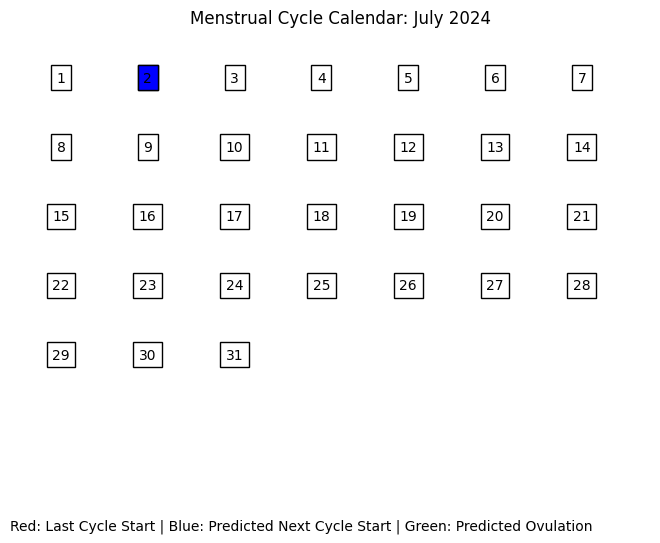

In [66]:
import calendar
import matplotlib.pyplot as plt

# Use the already defined datetime variables
year, month = next_cycle_date.year, next_cycle_date.month
cal = calendar.monthcalendar(year, month)

fig, ax = plt.subplots(figsize=(8, 6))
ax.set_title(f'Menstrual Cycle Calendar: {calendar.month_name[month]} {year}')
ax.axis('off')

# Draw calendar grid
for week_idx, week in enumerate(cal):
    for day_idx, day in enumerate(week):
        if day != 0:
            ax.text(day_idx * 0.14 + 0.05, 0.9 - week_idx * 0.15, str(day), 
                    ha='center', va='center', bbox=dict(facecolor='white', edgecolor='black'))
            # Highlight key dates
            current_date = datetime(year, month, day)
            if current_date == last_cycle_date:
                ax.text(day_idx * 0.14 + 0.05, 0.9 - week_idx * 0.15, str(day), 
                        ha='center', va='center', bbox=dict(facecolor='red', edgecolor='black'))
            elif current_date == next_cycle_date:
                ax.text(day_idx * 0.14 + 0.05, 0.9 - week_idx * 0.15, str(day), 
                        ha='center', va='center', bbox=dict(facecolor='blue', edgecolor='black'))
            elif current_date == ovulation_date:
                ax.text(day_idx * 0.14 + 0.05, 0.9 - week_idx * 0.15, str(day), 
                        ha='center', va='center', bbox=dict(facecolor='green', edgecolor='black'))

# Add legend
plt.figtext(0.1, 0.05, "Red: Last Cycle Start | Blue: Predicted Next Cycle Start | Green: Predicted Ovulation")
plt.show()

In [70]:
# Example feedback data with historical cycles
new_data = {
    'LengthofCycle': 27,  # Actual cycle length, slightly off from prediction
    'MeanCycleLength': 28.0,
    'EstimatedDayofOvulation': 14,  # Actual ovulation day
    'LengthofLutealPhase': 13,  # 27 - 14
    'Age': 29.0,
    'BMI': 23.0,
    'LengthofMenses': 5.0,
    'MeanMensesLength': 4.8,
    'TotalMensesScore': 8.0,
    'OvulationFraction': 14/27,  # Computed as EstimatedDayofOvulation / LengthofCycle
    'LutealPhaseRatio': 13/27,  # 13/27 ≈ 0.481
    'CycleLengthVar': 1.8,  # Will be updated by historical cycles
    'OvulationDayVar': 1.2  # Will be updated by historical cycles
}

historical_cycles = [
    {'LengthofCycle': 28, 'EstimatedDayofOvulation': 14},  # Previous cycle 1
    {'LengthofCycle': 26, 'EstimatedDayofOvulation': 13},  # Previous cycle 2
    {'LengthofCycle': 29, 'EstimatedDayofOvulation': 15}   # Previous cycle 3
]

# Update model with new data and historical cycles
try:
    update_model_with_feedback(new_data, historical_cycles)
except Exception as e:
    print(f"Error updating model with feedback: {e}")

Updated data saved to: d:\Projects\menstrual_cycle_prediction\preprocessed_menstrual_data_optimized.csv
Models retrained and saved successfully.


Welcome to the Menstrual Cycle Predictor (Healthcare App)

Predicted Next Cycle Date: 2025-06-08
Predicted Ovulation Date: 2025-05-25
Error: could not convert string to float: ''. Please ensure all inputs are valid numbers or dates.


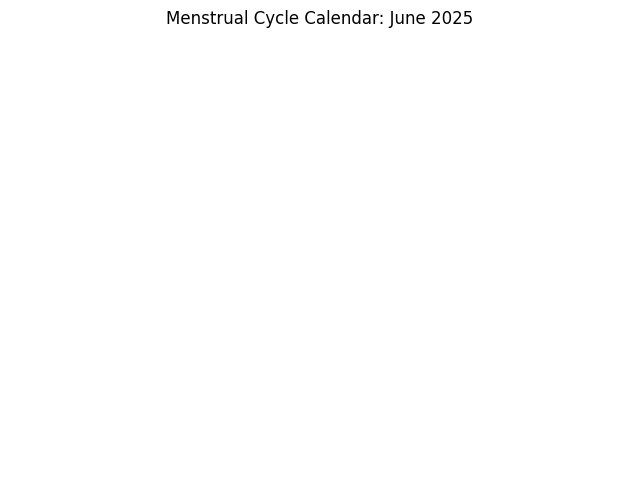

In [72]:
# Cell 8: Interactive Testing Interface (Unchanged)
def interactive_predictor():
    """
    Interactive function to collect user input and predict cycle dates.
    """
    print("Welcome to the Menstrual Cycle Predictor (Healthcare App)")
    try:
        last_cycle_date = input("Enter last cycle start date (YYYY-MM-DD): ")
        mean_cycle_length = float(input("Enter average cycle length (days): "))
        age = float(input("Enter age (years): "))
        bmi = float(input("Enter BMI: "))
        length_of_menses = float(input("Enter length of menses (days): "))
        mean_menses_length = float(input("Enter average menses length (days): "))
        total_menses_score = float(input("Enter total menses score: "))
        cycle_length_var = float(input("Enter cycle length variability (std dev, 0 if unknown): "))
        ovulation_day_var = float(input("Enter ovulation day variability (std dev, 0 if unknown): "))
        luteal_phase_ratio = float(input("Enter luteal phase ratio (luteal length/cycle length, 0.5 if unknown): "))
        
        next_cycle, ovulation = predict_next_cycle(
            last_cycle_date, mean_cycle_length, age, bmi,
            length_of_menses, mean_menses_length, total_menses_score,
            cycle_length_var, ovulation_day_var, luteal_phase_ratio
        )
        print(f"\nPredicted Next Cycle Date: {next_cycle}")
        print(f"Predicted Ovulation Date: {ovulation}")
        
        # Plot calendar
        plot_cycle_calendar(last_cycle_date, next_cycle, ovulation)
        
        # Offer to save feedback
        save_feedback = input("Would you like to save this data to improve the model? (yes/no): ").lower()
        if save_feedback == 'yes':
            actual_cycle_length = float(input("Enter actual cycle length (days): "))
            actual_ovulation_day = float(input("Enter actual ovulation day: "))
            historical_cycles = []
            add_history = input("Would you like to add historical cycle data? (yes/no): ").lower()
            if add_history == 'yes':
                num_cycles = int(input("How many past cycles to add? "))
                for i in range(num_cycles):
                    cycle_length = float(input(f"Enter cycle length for past cycle {i+1} (days): "))
                    ovulation_day = float(input(f"Enter ovulation day for past cycle {i+1}: "))
                    historical_cycles.append({'LengthofCycle': cycle_length, 'EstimatedDayofOvulation': ovulation_day})
            
            new_data = {
                'LengthofCycle': actual_cycle_length,
                'MeanCycleLength': mean_cycle_length,
                'EstimatedDayofOvulation': actual_ovulation_day,
                'LengthofLutealPhase': actual_cycle_length - actual_ovulation_day,
                'Age': age,
                'BMI': bmi,
                'LengthofMenses': length_of_menses,
                'MeanMensesLength': mean_menses_length,
                'TotalMensesScore': total_menses_score,
                'CycleLengthVar': cycle_length_var,
                'OvulationDayVar': ovulation_day_var,
                'LutealPhaseRatio': luteal_phase_ratio
            }
            update_model_with_feedback(new_data, historical_cycles)
    except ValueError as e:
        print(f"Error: {e}. Please ensure all inputs are valid numbers or dates.")
    except Exception as e:
        print(f"An unexpected error occurred: {e}")

# Run the interactive predictor
interactive_predictor()